# Imports

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import google.colab
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats
from sklearn.feature_selection import f_classif

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
music_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/Music/light_spotify_dataset.csv")

# EDA and cleaning

In [14]:
import re

def normalize_cell(val):
    if isinstance(val, str):
        # Lowercase
        #val = val.lower()
        # Remove leading/trailing spaces
        val = val.strip()
        # Replace multiple spaces inside with a single space
        val = re.sub(r'\s+', ' ', val)
        return val
    else:
        return val  # return numbers unchanged

def normalize_dataframe(df):
    df.columns = [normalize_cell(col) for col in df.columns]
    df.columns = [x.lower() for x in df.columns] # Apply lower to each element of the Index
    df = df.applymap(normalize_cell)
    return df

In [27]:
thirst_rows = music_df[music_df['emotion'] == 'thirst']
pink_rows = music_df[music_df['emotion'] == 'pink']
true_rows = music_df[music_df['emotion'] == 'True']
combined_rows = pd.concat([thirst_rows, pink_rows, true_rows])

df = music_df.copy()
df = df[~df['emotion'].isin(['thirst', 'pink', 'True'])]
df.loc[df['emotion'] == 'angry', 'emotion'] = 'anger'
df.groupby('emotion').size()
df = normalize_dataframe(df)
df = df.dropna()
df = df.drop_duplicates()
top_genres = df['genre'].value_counts().nlargest(11).index
df['genre']=df['genre'].apply(lambda x: x if x in top_genres else 'other')
df['genre']=df['genre'].replace('Unknown,Unknown,Unknown','other')

df['speechiness_log'] = np.log1p(df['speechiness'])
df['instrumentalness_bin'] = (df['instrumentalness'] > 0).astype(int)
df['mode_int'] = df['key'].str.contains('Maj').astype(int)
key_mapping = {'C':0, 'C#':1, 'D':2, 'D#':3, 'E':4, 'F':5, 'F#':6, 'G':7, 'G#':8, 'A':9, 'A#':10, 'B':11}
df['key_root'] = df['key'].str.split().str[0].map(key_mapping)
df['cos_pitch'] = np.cos(2 * np.pi * df['key_root'] / 12)
df['sin_pitch'] = np.sin(2 * np.pi * df['key_root'] / 12)
df3 = df.copy()
#print(df['Genre'].value_counts(normalize=True).sum())

<ipython-input-14-cd6ae81b7231>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(normalize_cell)
<ipython-input-27-533efe71932c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre']=df['genre'].apply(lambda x: x if x in top_genres else 'other')


                         tempo  loudness    energy  danceability  \
tempo                 1.000000  0.116967  0.171032     -0.091356   
loudness              0.116967  1.000000  0.747994      0.123130   
energy                0.171032  0.747994  1.000000      0.023415   
danceability         -0.091356  0.123130  0.023415      1.000000   
positiveness          0.043108  0.162590  0.292641      0.392165   
speechiness_log       0.053150  0.166578  0.208501      0.308743   
liveness              0.006788  0.075841  0.171424     -0.115513   
acousticness         -0.157458 -0.538370 -0.665536     -0.152093   
instrumentalness_bin  0.017769 -0.189521 -0.015653     -0.180335   
cos_pitch             0.018904  0.012311  0.009507      0.041817   
sin_pitch            -0.008164 -0.009676 -0.015991     -0.017432   
mode_int              0.005402 -0.075014 -0.076767     -0.087514   

                      positiveness  speechiness_log  liveness  acousticness  \
tempo                     0.043108  

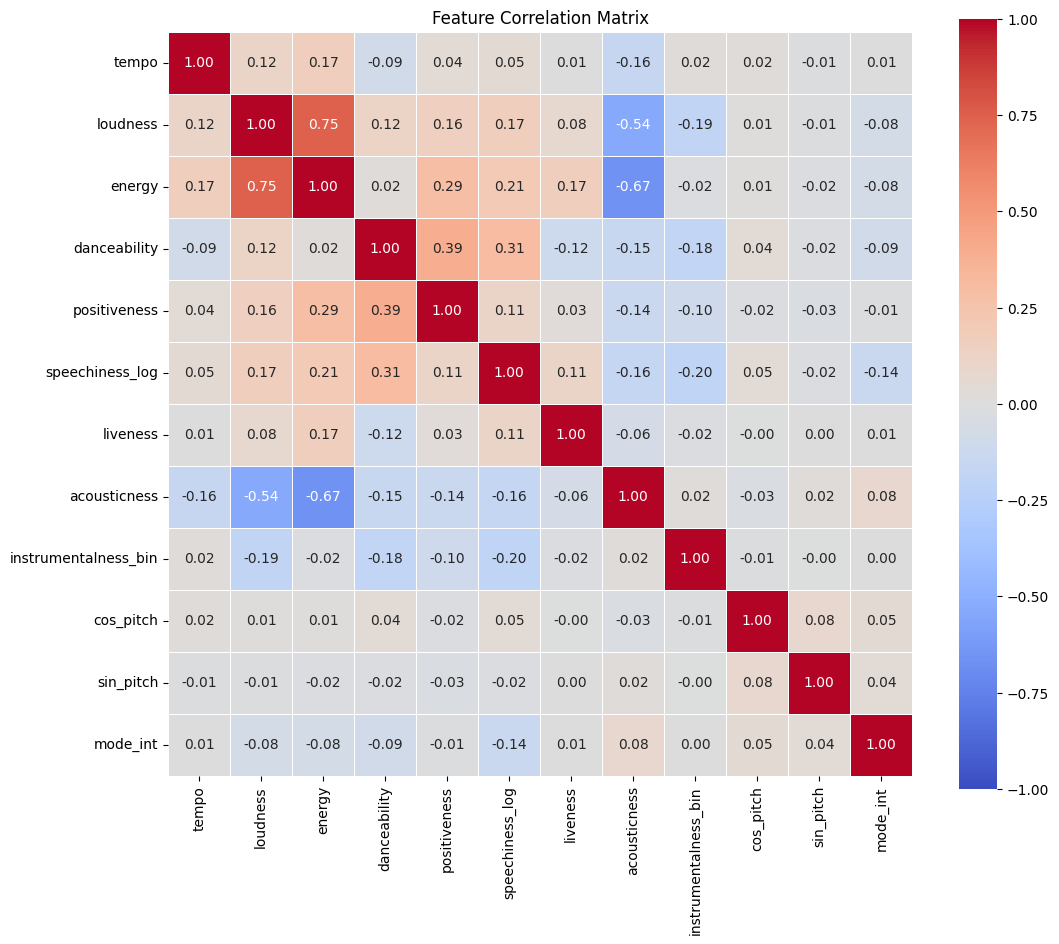

In [16]:
#numerical_columns = ['variance','tempo','loudness','popularity','energy','danceability','positiveness','speechiness',
#                     'speechiness_log','liveness','acousticness', 'instrumentalness','instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int','key_root']
feature_columns = ['tempo','loudness','energy','danceability','positiveness',
                     'speechiness_log','liveness','acousticness','instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int']
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (no need to scale)
corr_matrix = df[feature_columns].corr()

# Display the correlation matrix numerically
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [20]:
df4 = df.copy()

In [21]:
# prompt: remove all non numeric columns from df4

# Assuming df4 is defined as in the previous code

# Select only numeric columns
df4 = df4.select_dtypes(include=np.number)


In [22]:
df4.head()

,variance,release date,tempo,loudness,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness,speechiness_log,instrumentalness_bin,mode_int,key_root,cos_pitch,sin_pitch
0,0.447619,2014,128,-6.00,31,78,56,60,3,31,7,0,1.386294,0,1,5,-0.866025,0.500000
1,0.202222,1980,102,-10.72,59,36,52,38,2,7,68,0,1.098612,0,1,10,0.500000,-0.866025
2,0.300881,1979,139,-5.70,50,78,85,97,3,8,20,2,1.386294,1,1,4,-0.500000,0.866025
3,0.355000,1975,132,-3.00,52,76,50,89,3,32,3,0,1.386294,0,1,5,-0.866025,0.500000
4,0.355000,1975,132,-3.00,52,76,50,89,3,32,3,0,1.386294,0,1,5,-0.866025,0.500000


In [1]:
df.head()

NameError: name 'df' is not defined

In [29]:
# prompt: tKE THE FIRST 100 ROWS IN THE DATAFRAM AND MAKE ME DOWNLIAD IT TO MY COMPUTER

from google.colab import files

# Assuming music_df is already defined as in your provided code

# Take the first 100 rows
first_100_rows = df

# Convert the DataFrame to a CSV file and save it temporarily
first_100_rows.to_csv('first_100_rows.csv', index=False)

# Download the saved file
files.download('first_100_rows.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test

In [ ]:
df.groupby('emotion').size()

,0
emotion,
anger,47191
fear,11960
joy,91528
love,12802
sadness,71156
surprise,2332


In [28]:
df

,artist,song,emotion,variance,genre,release date,key,tempo,loudness,explicit,...,speechiness,liveness,acousticness,instrumentalness,speechiness_log,instrumentalness_bin,mode_int,key_root,cos_pitch,sin_pitch
0,ABBA,She's My Kind Of Girl,joy,0.447619,pop,2014,F Maj,128,-6.00,No,...,3,31,7,0,1.386294,0,1,5,-8.660254e-01,5.000000e-01
1,ABBA,"Andante, Andante",love,0.202222,pop,1980,A# Maj,102,-10.72,No,...,2,7,68,0,1.098612,0,1,10,5.000000e-01,-8.660254e-01
2,ABBA,As Good As New,sadness,0.300881,pop,1979,E Maj,139,-5.70,No,...,3,8,20,2,1.386294,1,1,4,-5.000000e-01,8.660254e-01
3,ABBA,Bang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,...,3,32,3,0,1.386294,0,1,5,-8.660254e-01,5.000000e-01
4,ABBA,Bang-A-Boomerang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,...,3,32,3,0,1.386294,0,1,5,-8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236983,(Eri Sasaki),Gate Of Steiner,sadness,0.833514,other,2018,D min,148,-6.44,No,...,4,14,20,0,1.609438,0,0,2,5.000000e-01,8.660254e-01
236984,(Elena Tsagrinou),El Diablo,love,0.833514,other,2021,A min,114,-7.78,No,...,13,84,0,0,2.639057,0,0,9,-1.836970e-16,-1.000000e+00
236985,(Dima Bilan),Believe,joy,0.833514,other,2009,C min,134,-6.72,No,...,5,22,5,0,1.791759,0,0,0,1.000000e+00,0.000000e+00
236986,(Ani Lorak),Shady Lady,joy,0.833514,other,2009,F# min,128,-13.00,No,...,5,7,5,0,1.791759,0,0,6,-1.000000e+00,1.224647e-16


In [ ]:
# === 0. Sample data ===
sample_fraction = 0.1  # train on 10% of data
df_sample = df3.sample(frac=sample_fraction, random_state=42)

# === 1. Data preprocessing ===
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sample[feature_columns])

# === 2. Build autoencoder ===
input_dim = scaled_features.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# === 3. Train autoencoder ===
autoencoder.fit(scaled_features, scaled_features, epochs=25, batch_size=16, verbose=1)

# === 4. Get latent embeddings ===
latent_vectors = encoder.predict(scaled_features)

# === 5. Recommend songs ===
def recommend_from_embedding(query_idx, latent_vectors, df, n_neighbors=5):
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1)
    nn.fit(latent_vectors)

    distances, indices = nn.kneighbors([latent_vectors[query_idx]])
    neighbor_indices = [idx for idx in indices[0] if idx != query_idx][:n_neighbors]

    print("\n🎵 Recommendations:")
    for i, idx in enumerate(neighbor_indices):
        print(f"{i+1}. {df.iloc[idx]['artist']} - {df.iloc[idx]['song']} (distance={distances[0][i+1]:.4f})")
    return neighbor_indices

# === 6. Example usage ===
query_idx = df_sample[
    (df_sample['artist'].str.lower() == "ariana grande") &
    (df_sample['song'].str.lower() == "problem")
].index

if len(query_idx) == 0:
    print("Song not found in sampled data.")
else:
    recommend_from_embedding(query_idx[0], latent_vectors, df_sample, n_neighbors=5)


Epoch 1/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6406
Epoch 2/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4838
Epoch 3/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4727
Epoch 4/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4675
Epoch 5/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4629
Epoch 6/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4601
Epoch 7/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4439
Epoch 8/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4404
Epoch 9/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4317
Epoch 10/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4327
Epoch 11/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4343
Epoch 12/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4300
Epoch 13/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4287
Epoch 14/25
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4309
Epoch 15/25
1482/1482 ━━━━━━━

In [ ]:
def print_song_features(artist_name, song_name, dataframe, feature_columns):
    """
    Print only the feature columns for a song in the dataframe.
    """
    # Filter to matching row
    matches = dataframe[
        (dataframe['artist'].str.lower() == artist_name.lower()) &
        (dataframe['song'].str.lower() == song_name.lower())
    ]

    if matches.empty:
        print(f"❌ No song found for '{artist_name} - {song_name}'.")
    else:
        # Select only feature columns (in case others exist)
        features_only = matches[feature_columns]
        print(features_only.to_string(index=False, header=True))
